In [1]:
import os

from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import imageio

%matplotlib inline

Для воспроизводимости результатов зафиксируем random seed

In [2]:
np.random.seed(92)

### Задача
Представленный ниже код апроксимирует зашумленную функцию $y = 3.5x - 7.3$

In [3]:
def func(x):
    return 3.5 * x - 7.3

Определим наборы данных

In [4]:
dataset_len = 30

X = np.linspace(dataset_len / -2, dataset_len / 2, dataset_len)
noise = np.random.randn(dataset_len)
Y = func(X) + noise

Для достижения большей репрезентативности выборок берется каждое 3 значение

In [5]:
x_train, x_val, x_test = X[0::3], X[1::3], X[2::3]
y_train, y_val, y_test = Y[0::3], Y[1::3], Y[2::3]

Перемешаем каждый набор данных

In [6]:
train_indexes = np.random.permutation(x_train.shape[0])
val_indexes = np.random.permutation(x_val.shape[0])
test_indexes = np.random.permutation(x_test.shape[0])

x_train, y_train = x_train[train_indexes], y_train[train_indexes]
x_val, y_val = x_val[val_indexes], y_val[val_indexes]
x_test, y_test = x_test[test_indexes], y_test[test_indexes]

На графике приближаемая функция выглядит следующим образом:

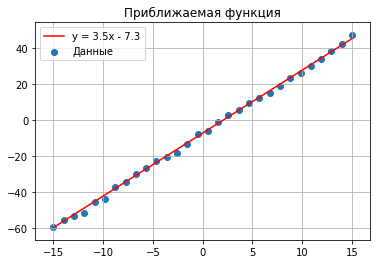

In [21]:
plt.plot(X, func(X), 'r', label='y = 3.5x - 7.3')
plt.scatter(X, Y, label='Данные')
plt.title('Приближаемая функция')
plt.legend()
plt.grid()

### Функция ошибок

В качестве loss-функции используется MSE

$$MSE = \frac{1}{n} * \sum_{i=1}^n (y_{pred}(i) - y_{expected}(i))^2 $$

In [8]:
def MSE(y_predicted, y_expected):
    return np.square(y_predicted - y_expected).mean()

Значение loss-функции между "чистыми" и зашумленными данными

In [9]:
MSE(func(X), Y)

0.9745288160360759

В данном случае представлена оптимизация функции в двумерном пространстве, но выполняемый при этом код позволяет работать с большим количеством размерностей

In [10]:
input_size = 1
output_size = 1

Приближаемая функция имеет вид $y = wx + b$.

Определим оптимизируемые параметры.

Умножение на 5 необходимо для более наглядной визуализации процесса обучения

In [11]:
w = np.random.randn(input_size, output_size) * 5
b = np.random.randn(1, output_size) * 5

w, b

(array([[1.25597337]]), array([[1.44926879]]))

### Функция прямого распространения

Определим функцию, выполняющую вычисление при текущем наборе параметров

In [12]:
def predict(x):
    x = np.array(x).reshape(-1, input_size)
    result = x @ w + b
    return result.reshape(-1, output_size)

In [13]:
predict(X[0])

array([[-17.39033173]])

## Метод градиентного спуска

### Градиент предсказания по весам

$$(\vec{x}w + \vec{b})_{ij} = \sum_{r=0}^n (x_{r} * w_{rj})$$

$$\frac{d(\vec{x}w + \vec{b})}{d w_{ij}} = x_i$$

\begin{equation*}
\frac{d(\vec{x}w + \vec{b})}{d w} =
\begin{bmatrix}
\frac{d(\vec{x}w + \vec{b})}{d w_{11}} & ... & \frac{d(\vec{x}w + b)}{d w_{1m}} \\
... & ... & ... \\
\frac{d(\vec{x}w + \vec{b})}{d w_{n1}} & ... & \frac{d(\vec{x}w + b)}{d w_{nm}}
\end{bmatrix}
\end{equation*}

\begin{equation*}
\frac{d(\vec{x}w + \vec{b})}{d w} = 
\begin{bmatrix}
x_1 & ... & x_1 \\
... & ... & ... \\
x_n & ... & x_n
\end{bmatrix}
\end{equation*}

\begin{equation*}
\frac{d(\vec{x}w + \vec{b})}{d w} = X^T
\end{equation*}

### Градиент предсказания по смещению

$$\frac{d(xw + \vec{b})}{d b} = 
\begin{bmatrix}
1 & ... & 1
\end{bmatrix}
$$

### Градиент Loss-функции по предсказанию

$$\frac{d MSE}{d y_{pred}} = \frac{2}{n} * (y_{pred}(i) - y_{expected}(i))$$

### Граддиент Loss-функции по весам

$$\frac{d MSE}{d w} = \frac{d MSE}{d y_{pred}} * \frac{d y_{pred}}{d w}$$

$$
\frac{d MSE}{d w} = \frac{2}{n} * (y_{pred}(i) - y_{expected}(i)) \cdot X^T
$$

### Градиент Loss-функции по смещению

$$\frac{d MSE}{d b} = \frac{d MSE}{d y_{pred}} * \frac{d y_{pred}}{d b}$$

$$\frac{d MSE}{d b} = \frac{2}{n} * (y_{pred}(i) - y_{expected}(i)) * 
\begin{bmatrix}
1 & ... & 1
\end{bmatrix}
$$

$$\frac{d MSE}{d b} = \frac{2}{n} * (y_{pred}(i) - y_{expected}(i))$$

$$\frac{d MSE}{d b} = \frac{d MSE}{d y_{pred}}$$

### Обновление весов

$$w_{t+1} = w_t - \alpha * \frac{d MSE}{d w}$$

$$b_{t+1} = b_t - \alpha * \frac{d MSE}{d b}$$

### Функция обратного распространения ошибки

Реализуем функцию обратного распространения

In [14]:
def backward_pass(x, y_pred, y_expected, lr):
    global w
    global b
    
    x = np.array(x).reshape(input_size,)
    
    x = np.array(x).reshape(1, input_size)
    
    dloss_dy = 2.0 / output_size * (y_pred - y_expected)
    
    dy_dw = x.T
    dy_db = 1
    
    dloss_dw = dy_dw @ dloss_dy
    dloss_db = dy_db * dloss_dy
    
    w -= lr * dloss_dw
    b -= lr * dloss_db

### Функция обучения модели

In [15]:
def fit(x_train, y_train, x_val, y_val, epochs_number, lr=0.001, early_stopping_rounds=2, 
        verbose=10, plotting_period=-1, plots_folder='plots', gif_filename='learning.gif'):
    if plots_folder and not os.path.exists(plots_folder):
        os.mkdir(plots_folder)
        
    train_loss_history = []
    val_loss_history = []
    fig = plt.figure()
    plots_counter = 0
    
    best_loss = MSE(predict(x_val).reshape(-1), y_val)
    best_loss_epoch = 0
    
    for epoch in tqdm(range(epochs_number)):
        
        if plotting_period > 0 and (epoch + 1) % plotting_period == 0:
            val_loss = MSE(predict(x_val).reshape(-1), y_val)
            plt.plot(x_val, predict(x_val), label=f'Epoch: {epoch + 1}; MSE: {val_loss}', c='red')
            plt.scatter(X, Y, c='green')
            plt.legend()
            plt.savefig(os.path.join(plots_folder, str(plots_counter)))
            plt.clf()
            plt.close(fig)
            plots_counter += 1
        
        for i in range(len(x_train)):
            x = x_train[i]
            y_expected = y_train[i]
            y_pred = predict(x)

            backward_pass(x, y_pred, y_expected, lr)

        train_loss_history.append(MSE(predict(x_train).reshape(-1), y_train))
        val_loss_history.append(MSE(predict(x_val).reshape(-1), y_val))
        
        if val_loss_history[-1] < best_loss:
            best_loss = val_loss_history[-1]
            best_loss_epoch = epoch
        elif val_loss_history[-1] > best_loss and early_stopping_rounds > 0:
            if epoch - best_loss_epoch > early_stopping_rounds:
                print(f'Early stopping. Epoch {epoch + 1}. Current loss: {val_loss_history[-1]}')
                break
        
        if verbose > 0 and (epoch + 1) % verbose == 0:
            print(f'{epoch+1}: train_loss: {train_loss_history[-1]}; val_loss: {val_loss_history[-1]}')
    
    if plotting_period and gif_filename:
        filenames = range(len(os.listdir(plots_folder)))

        images = []
        for filename in filenames:
            images.append(imageio.imread(os.path.join(plots_folder, f'{filename}.png')))
        imageio.mimsave(gif_filename, images, fps=10)
    
    plt.close()
    
    return train_loss_history, val_loss_history

Запустим процесс обучения

In [16]:
train_loss_history, val_loss_history = fit(
    x_train, y_train, x_val, y_val, epochs_number=150, 
    verbose=10, plotting_period=1
)

10: train_loss: 55.59337798537698; val_loss: 47.91838788513529
20: train_loss: 36.586563905274396; val_loss: 30.215961073580065
30: train_loss: 24.217019590212878; val_loss: 18.922155314098696
40: train_loss: 16.167500231747194; val_loss: 11.755754179370651
50: train_loss: 10.929671281064373; val_loss: 7.240332893006605
60: train_loss: 7.521751213237008; val_loss: 4.421705169253434
70: train_loss: 5.304709844709056; val_loss: 2.6843094324559624
80: train_loss: 3.862622513159026; val_loss: 1.6319399157090846
90: train_loss: 2.924787141226753; val_loss: 1.0103145061880017
100: train_loss: 2.3150271434761445; val_loss: 0.6568368351406084
110: train_loss: 1.9186910581900538; val_loss: 0.4680285459617276
120: train_loss: 1.661171853825375; val_loss: 0.3784381244962832
130: train_loss: 1.493924902872535; val_loss: 0.3469994904203494
Early stopping. Epoch 137. Current loss: 0.3455010748802375


Изменение функции во время обучения сохранено в gif-файл

In [17]:
Image(url="learning.gif")

Значение loss-функции стало возрастать, что привело к срабатываю механизма преждевременной остановки обучения

### Визуализация результатов

График обучения

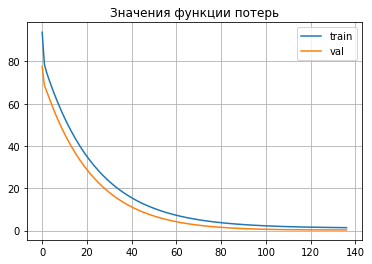

In [18]:
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.title('Значения функции потерь')
plt.legend()
plt.grid()

Сравним значения приближаемой и полученной в результате обучения функций

In [19]:
expected_model_prediction = func(x_test)
actual_model_prediction = predict(x_test).reshape(-1)

expected_model_loss = MSE(expected_model_prediction, y_test)
actual_model_loss = MSE(actual_model_prediction, y_test)

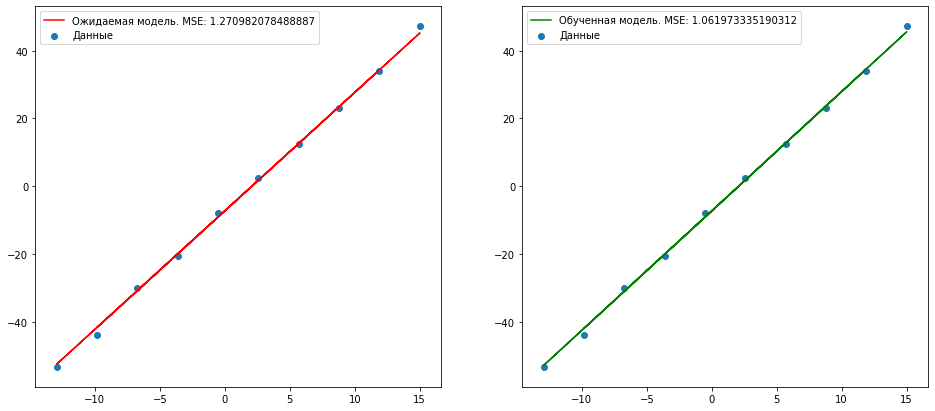

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

ax[0].plot(x_test, expected_model_prediction, 'r', label=f'Ожидаемая модель. MSE: {expected_model_loss}')
ax[0].scatter(x_test, y_test, label='Данные')
ax[0].legend()

ax[1].plot(x_test, actual_model_prediction, 'g', label=f'Обученная модель. MSE: {actual_model_loss}')
ax[1].scatter(x_test, y_test, label='Данные')
ax[1].legend()

plt.show()